<h1>contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#setup" data-toc-modified-id="setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>setup</a></span></li><li><span><a href="#neural-network-architecture" data-toc-modified-id="neural-network-architecture-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>neural network architecture</a></span></li><li><span><a href="#data" data-toc-modified-id="data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>data</a></span></li><li><span><a href="#experiments" data-toc-modified-id="experiments-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>experiments</a></span><ul class="toc-item"><li><span><a href="#random-grid-search" data-toc-modified-id="random-grid-search-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>random grid search</a></span></li><li><span><a href="#results" data-toc-modified-id="results-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>results</a></span></li></ul></li></ul></div>

# setup

In [1]:
import datetime
import gc
import json
import os
import pprint
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.preprocessing import MinMaxScaler

import geopandas as gpd
import folium

from IPython.display import display

mpl.rcParams.update(mpl.rcParamsDefault)
warnings.filterwarnings("ignore")

%matplotlib inline

In [2]:
sns.set_style("whitegrid")

plt.rcParams.update({
    'font.size'       : 9,
    'figure.figsize'  : (3.5, 2.8),
    'figure.dpi'      : 300,
    'savefig.dpi'     : 300,
    'text.usetex'     : True,
    'font.family'     : 'serif',
    'font.serif'      : ['Times New Roman'],
    'axes.labelsize'  : 9,
    'axes.titlesize'  : 9,
    'xtick.labelsize' : 8,
    'ytick.labelsize' : 8,
    'legend.fontsize' : 8,
    'lines.linewidth' : 1,
    'axes.linewidth'  : 1,
    'grid.linestyle'  : '--',
    'grid.linewidth'  : 0.5,
    'grid.alpha'      : 0.8,
})

sns.set_context(
    "paper", 
    rc={
        "font.size"      : 9,
        "axes.titlesize" : 9,
        "axes.labelsize" : 9, 
        'xtick.labelsize': 8,
        'ytick.labelsize': 8
    }
)

In [3]:
experiment_name = "wildfire_spread"
folder_path = f"../data/08_reporting/{experiment_name}"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

golden_ratio = (np.sqrt(5) - 1) / 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# data

## `tfrecord` files

the code that reads tfrecord files is based on the kaggle notebook [https://www.kaggle.com/code/fantineh/data-reader-and-visualization](https://www.kaggle.com/code/fantineh/data-reader-and-visualization) which apparently was written by dataset creators themselves.

In [6]:
import re
from typing import Dict, List, Optional, Text, Tuple
import tensorflow as tf
from matplotlib import colors

file_pattern = "../data/01_raw/next-day-wildfire-spread/next_day_wildfire_spread_train_01*"

INPUT_FEATURES = [
    "elevation",
    "th",
    "vs",
    "tmmn",
    "tmmx",
    "sph",
    "pr",
    "pdsi",
    "NDVI",
    "population",
    "erc",
    "PrevFireMask",
]

OUTPUT_FEATURES = [
    "FireMask",
]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    "elevation": (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    "pdsi": (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    "NDVI": (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    "pr": (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    "sph": (0.0, 1.0, 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    "th": (0.0, 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    "tmmn": (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    "tmmx": (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    "vs": (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    "erc": (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    "population": (0.0, 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    "PrevFireMask": (-1.0, 1.0, 0.0, 1.0),
    "FireMask": (-1.0, 1.0, 0.0, 1.0),
}

"""Library of common functions used in deep learning neural networks.
"""


def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Randomly axis-align crop input and output image tensors.

    Args:
      input_img: tensor with dimensions HWC.
      output_img: tensor with dimensions HWC.
      sample_size: side length (square) to crop to.
      num_in_channels: number of channels in input_img.
      num_out_channels: number of channels in output_img.
    Returns:
      input_img: tensor with dimensions HWC.
      output_img: tensor with dimensions HWC.
    """
    combined = tf.concat([input_img, output_img], axis=2)
    combined = tf.image.random_crop(
        combined, [sample_size, sample_size, num_in_channels + num_out_channels]
    )
    input_img = combined[:, :, 0:num_in_channels]
    output_img = combined[:, :, -num_out_channels:]
    return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Center crops input and output image tensors.

    Args:
      input_img: tensor with dimensions HWC.
      output_img: tensor with dimensions HWC.
      sample_size: side length (square) to crop to.
    Returns:
      input_img: tensor with dimensions HWC.
      output_img: tensor with dimensions HWC.
    """
    central_fraction = sample_size / input_img.shape[0]
    input_img = tf.image.central_crop(input_img, central_fraction)
    output_img = tf.image.central_crop(output_img, central_fraction)
    return input_img, output_img


"""Dataset reader for Earth Engine data."""


def _get_base_key(key: Text) -> Text:
    """Extracts the base key from the provided key.

    Earth Engine exports TFRecords containing each data variable with its
    corresponding variable name. In the case of time sequences, the name of the
    data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
    where 'variable' is the name of the variable, and n the number of elements
    in the time sequence. Extracting the base key ensures that each step of the
    time sequence goes through the same normalization steps.
    The base key obeys the following naming pattern: '([a-zA-Z]+)'
    For instance, for an input key 'variable_1', this function returns 'variable'.
    For an input key 'variable', this function simply returns 'variable'.

    Args:
      key: Input key.

    Returns:
      The corresponding base key.

    Raises:
      ValueError when `key` does not match the expected pattern.
    """
    match = re.match(r"([a-zA-Z]+)", key)
    if match:
        return match.group(1)
    raise ValueError(
        "The provided key does not match the expected pattern: {}".format(key)
    )


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and rescales inputs with the stats corresponding to `key`.

    Args:
      inputs: Inputs to clip and rescale.
      key: Key describing the inputs.

    Returns:
      Clipped and rescaled input.

    Raises:
      ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            "No data statistics available for the requested key: {}.".format(key)
        )
    min_val, max_val, _, _ = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
    """Clips and normalizes inputs with the stats corresponding to `key`.

    Args:
      inputs: Inputs to clip and normalize.
      key: Key describing the inputs.

    Returns:
      Clipped and normalized input.

    Raises:
      ValueError if there are no data statistics available for `key`.
    """
    base_key = _get_base_key(key)
    if base_key not in DATA_STATS:
        raise ValueError(
            "No data statistics available for the requested key: {}.".format(key)
        )
    min_val, max_val, mean, std = DATA_STATS[base_key]
    inputs = tf.clip_by_value(inputs, min_val, max_val)
    inputs = inputs - mean
    return tf.math.divide_no_nan(inputs, std)


def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
    """Creates a features dictionary for TensorFlow IO.

    Args:
      sample_size: Size of the input tiles (square).
      features: List of feature names.

    Returns:
      A features dictionary for TensorFlow IO.
    """
    sample_shape = [sample_size, sample_size]
    features = set(features)
    columns = [
        tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32) for _ in features
    ]
    return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example,
    data_size: int,
    sample_size: int,
    num_in_channels: int,
    clip_and_normalize: bool,
    clip_and_rescale: bool,
    random_crop: bool,
    center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
    """Reads a serialized example.

    Args:
      example_proto: A TensorFlow example protobuf.
      data_size: Size of tiles (square) as read from input files.
      sample_size: Size the tiles (square) when input into the model.
      num_in_channels: Number of input channels.
      clip_and_normalize: True if the data should be clipped and normalized.
      clip_and_rescale: True if the data should be clipped and rescaled.
      random_crop: True if the data should be randomly cropped.
      center_crop: True if the data should be cropped in the center.

    Returns:
      (input_img, output_img) tuple of inputs and outputs to the ML model.
    """
    if random_crop and center_crop:
        raise ValueError("Cannot have both random_crop and center_crop be True")
    input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
    feature_names = input_features + output_features
    features_dict = _get_features_dict(data_size, feature_names)
    features = tf.io.parse_single_example(example_proto, features_dict)

    if clip_and_normalize:
        inputs_list = [
            _clip_and_normalize(features.get(key), key) for key in input_features
        ]
    elif clip_and_rescale:
        inputs_list = [
            _clip_and_rescale(features.get(key), key) for key in input_features
        ]
    else:
        inputs_list = [features.get(key) for key in input_features]

    inputs_stacked = tf.stack(inputs_list, axis=0)
    input_img = tf.transpose(inputs_stacked, [1, 2, 0])

    outputs_list = [features.get(key) for key in output_features]
    assert outputs_list, "outputs_list should not be empty"
    outputs_stacked = tf.stack(outputs_list, axis=0)

    outputs_stacked_shape = outputs_stacked.get_shape().as_list()
    assert len(outputs_stacked.shape) == 3, (
        "outputs_stacked should be rank 3"
        "but dimensions of outputs_stacked"
        f" are {outputs_stacked_shape}"
    )
    output_img = tf.transpose(outputs_stacked, [1, 2, 0])

    if random_crop:
        input_img, output_img = random_crop_input_and_output_images(
            input_img, output_img, sample_size, num_in_channels, 1
        )
    if center_crop:
        input_img, output_img = center_crop_input_and_output_images(
            input_img, output_img, sample_size
        )
    return input_img, output_img


def get_dataset(
    file_pattern: Text,
    data_size: int,
    sample_size: int,
    batch_size: int,
    num_in_channels: int,
    compression_type: Text,
    clip_and_normalize: bool,
    clip_and_rescale: bool,
    random_crop: bool,
    center_crop: bool,
) -> tf.data.Dataset:
    """Gets the dataset from the file pattern.

    Args:
      file_pattern: Input file pattern.
      data_size: Size of tiles (square) as read from input files.
      sample_size: Size the tiles (square) when input into the model.
      batch_size: Batch size.
      num_in_channels: Number of input channels.
      compression_type: Type of compression used for the input files.
      clip_and_normalize: True if the data should be clipped and normalized, False
        otherwise.
      clip_and_rescale: True if the data should be clipped and rescaled, False
        otherwise.
      random_crop: True if the data should be randomly cropped.
      center_crop: True if the data shoulde be cropped in the center.

    Returns:
      A TensorFlow dataset loaded from the input file pattern, with features
      described in the constants, and with the shapes determined from the input
      parameters to this function.
    """
    if clip_and_normalize and clip_and_rescale:
        raise ValueError("Cannot have both normalize and rescale.")
    dataset = tf.data.Dataset.list_files(file_pattern)
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(
        lambda x: _parse_fn(  # pylint: disable=g-long-lambda
            x,
            data_size,
            sample_size,
            num_in_channels,
            clip_and_normalize,
            clip_and_rescale,
            random_crop,
            center_crop,
        ),
        num_parallel_calls=tf.data.experimental.AUTOTUNE,
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [7]:
dataset = get_dataset(
    file_pattern,
    data_size=64,
    sample_size=32,
    batch_size=100,
    num_in_channels=12,
    compression_type=None,
    clip_and_normalize=False,
    clip_and_rescale=False,
    random_crop=True,
    center_crop=False,
)

In [8]:
inputs, labels = next(iter(dataset))

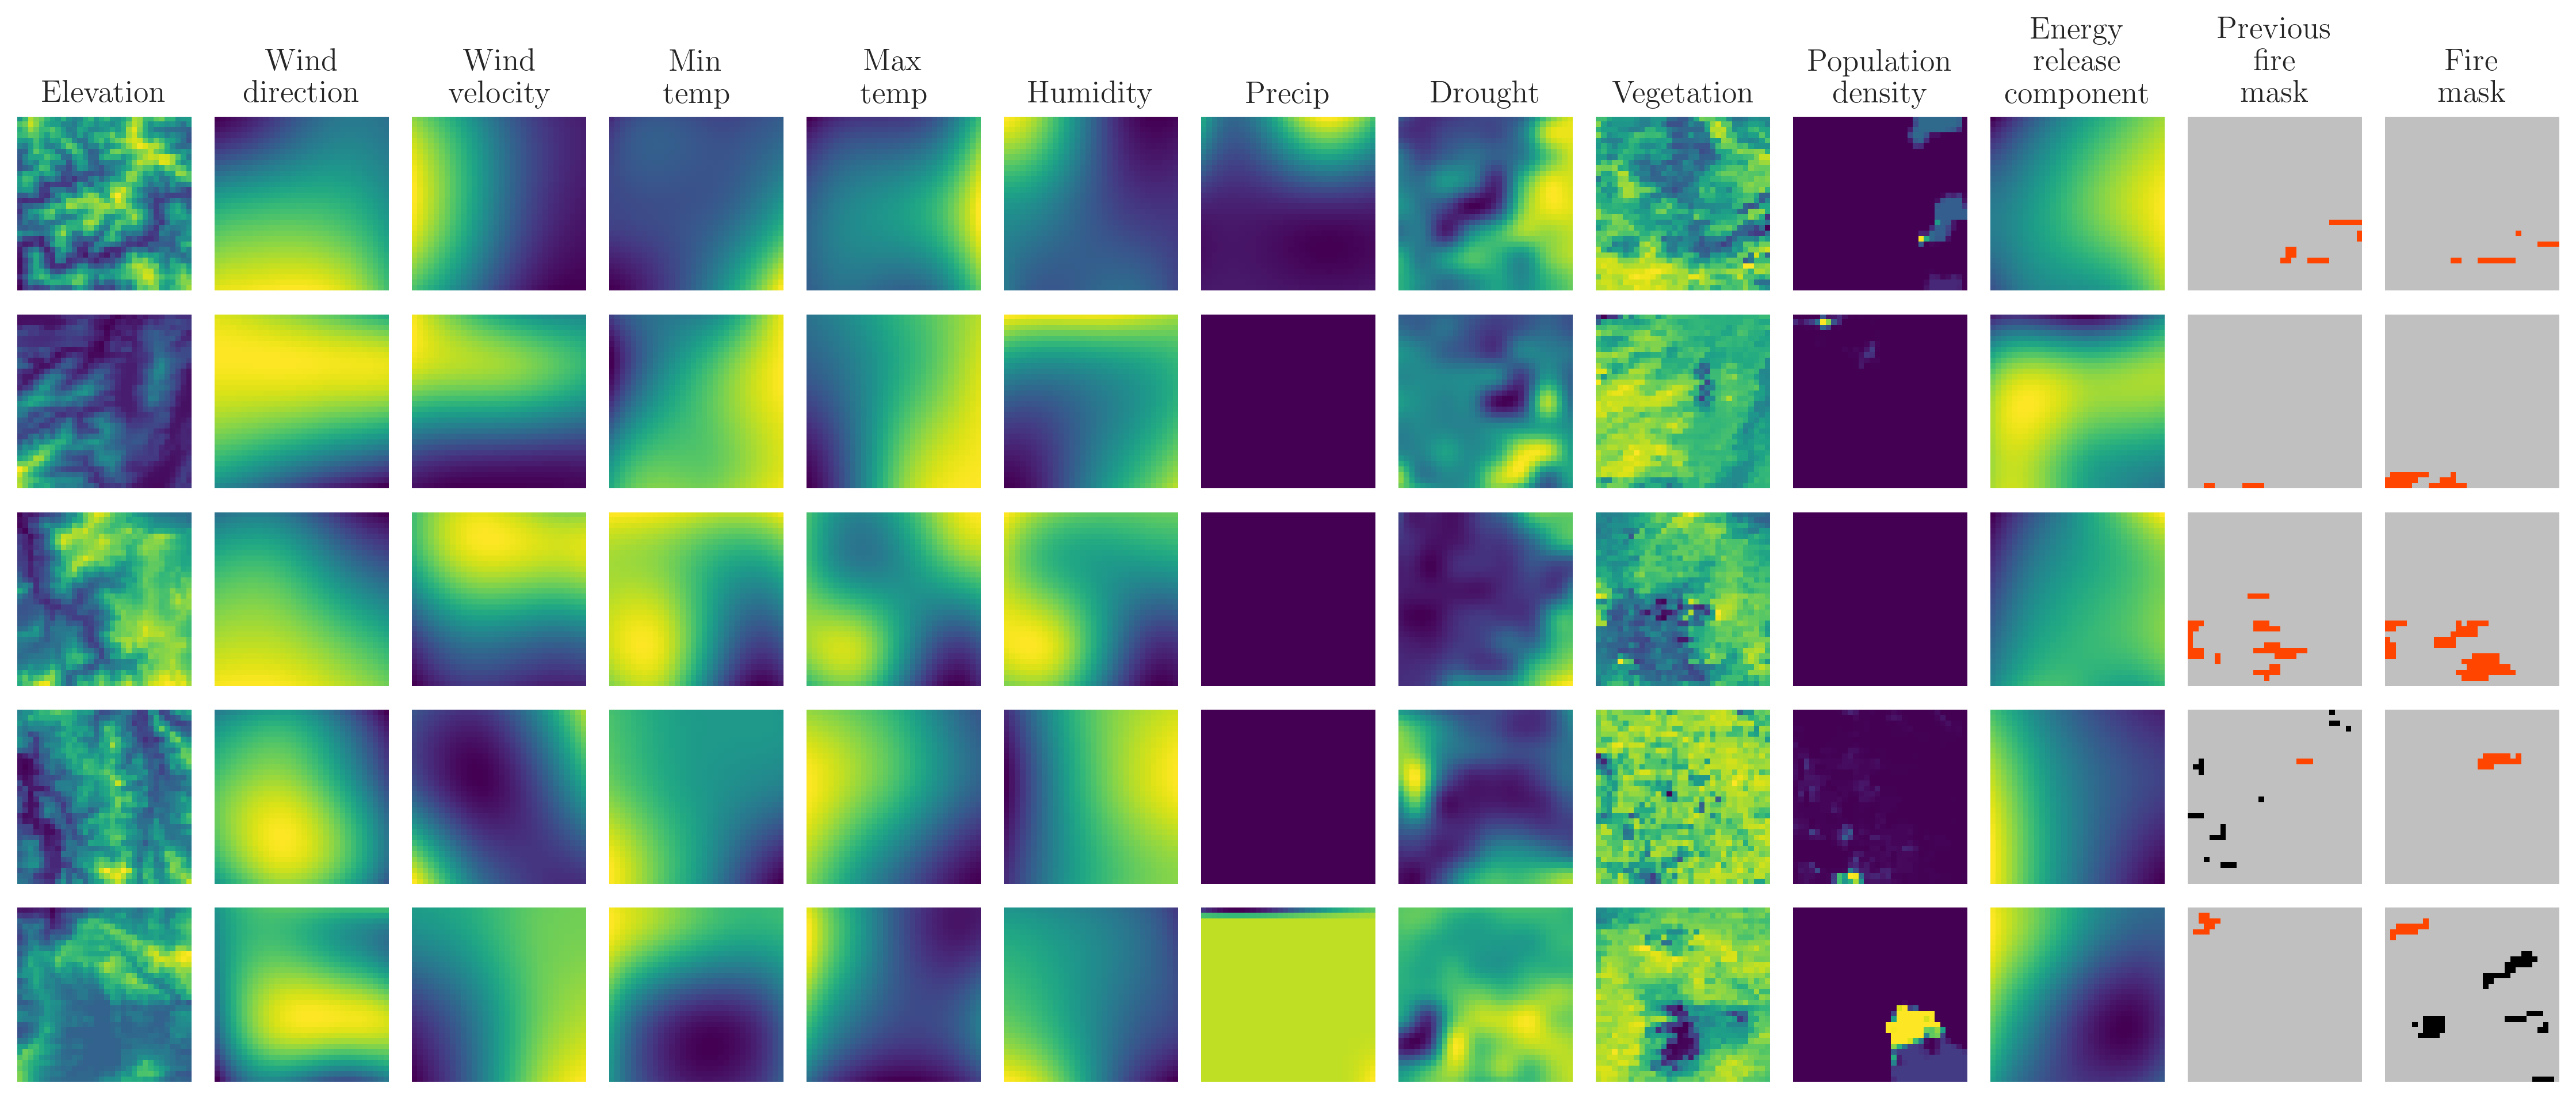

In [10]:
TITLES = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# Number of rows of data samples to plot
n_rows = 5 
# Number of data variables
n_features = inputs.shape[3]
# Variables for controllong the color map for the fire masks
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

fig = plt.figure(figsize=(15,6.5))

for i in range(n_rows):
  for j in range(n_features + 1):
    plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
    if i == 0:
      plt.title(TITLES[j], fontsize=13)
    if j < n_features - 1:
      plt.imshow(inputs[i, :, :, j], cmap='viridis')
    if j == n_features - 1:
      plt.imshow(inputs[i, :, :, -1], cmap=CMAP, norm=NORM)
    if j == n_features:
      plt.imshow(labels[i, :, :, 0], cmap=CMAP, norm=NORM) 
    plt.axis('off')
plt.tight_layout()

.